In [1]:
!pip install python-graphblas[default]
!pip install metagraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 4.1 MB/s eta 0:00:00


In [54]:
import graphblas as gb
from metagraph import concrete_algorithm, NodeID
from metagraph.plugins import has_grblas
from metagraph.plugins.core import exceptions
from typing import Tuple, Iterable, Any, Union, Optional
import numpy as np

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread

In [85]:
# Create initial data objects
edges = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
]
A = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
A

"M_125"    nvals  nrows  ncols  dtype         format
gb.Matrix     12      7      7   BOOL  bitmapr (iso)
----------------------------------------------------
      0     1     2     3     4     5     6
0        True        True                  
1                          True        True
2                                True      
3  True        True                        
4                                True      
5              True                        
6              True  True  True

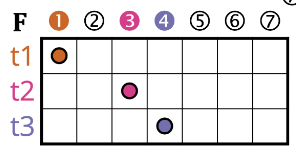

N=7, starts=[0,2,3], len(starts)=3
F[0, 0]=1
F[1,2]=1
F[2,3]=1


 * Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
  * Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
  * Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.


In [4]:
vertices=[0, 2, 3]

In [86]:
def MSFBS_levels(A, vertices):
    n = A.nrows
    result = gb.Matrix(int, len(vertices), n)  # vector for result with levels

    #колво столбцов = колво верщин графа, колво строк = колво стартовых вершин
    f = gb.Matrix(int, len(vertices), n)  # frontier

    for i in range (len(vertices)):
        f[i, vertices[i]]<< True #создать пустую матрицу и проставить единички в цикле

    succ =Vector(bool,len(vertices))
    #matrix = gb.Matrix.from_vectors([f1, f2, f3])
    level = 0  # level in BFS traversal
    while True:
        i=0
        # For the frontier, assign the depth level
        result(f.V) << level
        # Compute the next frontier, masking out anything already assigned
        f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)

        # If next frontier is empty, we're done
        succ << f.reduce_rowwise(monoid.lor)
        level += 1
        i+=1
        if succ.nvals == 0:
            break
    output = []
    for i, vertex in enumerate(vertices):
        levels = []
        for j in range(n):
            levels.append(result[i, j].value if result[i, j].value != None or j == vertex else -1)
        output.append((vertex, levels))

    # Print the result matrix
    return output
MSFBS_levels(A, vertices)

[(0, [0, 1, 2, 1, 2, 3, 2]),
 (2, [-1, -1, 0, -1, -1, 1, -1]),
 (3, [1, 2, 1, 0, 3, 2, 3])]

* Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.
  * Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
  * Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.


In [ ]:
#def MSFBS_parents(A, vertices):
#  pass
#N = A.nrows
#index_ramp = Vector(dtypes.UINT64, N)
#index_ramp.build(range(N), range(N))
#
#
#parents = gb.Matrix(int, len(vertices), N)
#for i in range (len(vertices)):
#    parents[i, vertices[i]]<<-1
#wavefront = gb.Matrix(int, len(vertices), N)
#for i in range (len(vertices)):
#    wavefront [i, vertices[i]]<<1
#
#while wavefront.nvals > 0:
#    i=0
#    # Convert all stored values in wavefront to their 0-based index
#    wavefront = index_ramp.ewise_mult(wavefront, binary.first)
#
#    # “FIRST” because left-multiplying wavefront rows. Masking out the parent
#    # list ensures wavefront values do not overwrite parents already stored.
#
#    wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
#
#    # Don’t need to mask here since we did it in mxm. Merges new parents in
#    # current wave front with existing parents : parents += wavefront
#    parents[binary.plus] = wavefront
#    i+=1
#parents

In [42]:
def MSFBS_parents(A, vertices):
  N = A.nrows
  index_ramp = Vector(dtypes.UINT64, N)
  index_ramp.build(range(N), range(N))
  output = []
  for vertex in vertices:
    parents = Vector(dtypes.INT64, N)
    parents[vertex] << -1
    wavefront = Vector(dtypes.INT64, N)
    wavefront[vertex] << 1
    while wavefront.nvals > 0:
      wavefront << index_ramp.ewise_mult(wavefront, binary.first)
      wavefront(~parents.S, replace=True) << wavefront.vxm(A, semiring.min_first)
      parents(binary.plus) << wavefront
    output.append((vertex, [parents.get(i, default=-2) for i in range(N)]))
  return output

In [43]:
MSFBS_parents(A, vertices)

[(1, [3, -1, 6, 6, 1, 4, 1]),
 (2, [-2, -2, -1, -2, -2, 2, -2]),
 (3, [3, 0, 3, -1, 1, 2, 1])]

 * (+2 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.


In [67]:
M1 = mmread('/content/sample_data/Untitled Folder/Erdos02.mtx')
M2 = mmread('/content/sample_data/Untitled Folder/Erdos972.mtx')
M3 = mmread('/content/sample_data/Untitled Folder/Erdos982.mtx')
M4 = mmread('/content/sample_data/Untitled Folder/Erdos992.mtx')
M5 = mmread('/content/sample_data/Untitled Folder/delaunay_n11.mtx')#/content/sample_data/Untitled Folder/ca-AstroPh.mtx
M6 = mmread('/content/sample_data/Untitled Folder/ca-CondMat.mtx')
M7 = mmread('/content/sample_data/Untitled Folder/delaunay_n13.mtx')
M8 = mmread('/content/sample_data/Untitled Folder/delaunay_n14.mtx')
M9 = mmread('/content/sample_data/Untitled Folder/delaunay_n12.mtx')#/content/sample_data/Untitled Folder/dblp-2010.mtx
M10 = mmread('/content/sample_data/Untitled Folder/delaunay_n15.mtx')

In [72]:
M=[M1, M2, M3,M4,M5,M6,M7,M8,M9,M10]

In [98]:
import random
def generate_random_graph(n, fill_count):
    # n -количество вершин, fill_count - степень разреженности
    m = gb.Matrix(int, n, n) #пустая матрица
    while fill_count > 0:
        i = random.randint(0, n-1)
        j = random.randint(0, n-1)
        if m.get(i,j) is None and i!= j: #если не пустое место, то ставим симметричную 1
            m[i,j] << True
            m[j,i] << True
            fill_count -= 1
    return m

In [101]:
import time
sizes = [100,1000, 5000, 10000, 99999]

for size in sizes:
  sparsities = [size - 1, 10, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
    vertices_ = [list(range(size - 1)), list(range(10)), list(range(size // 2))]
    for vertices in vertices_:
        start = time.time()
        MSFBS_levels(generate_random_graph(size, sparsity), vertices)
        print(f"Time {len(vertices)} vertices, size {size} and sparsity {sparsity} is {time.time() - start}s")

Time 99 vertices, size 100 and sparsity 99 is 0.6720187664031982s
Time 10 vertices, size 100 and sparsity 99 is 0.0820150375366211s
Time 50 vertices, size 100 and sparsity 99 is 0.37347984313964844s
Time 99 vertices, size 100 and sparsity 10 is 0.38878965377807617s
Time 10 vertices, size 100 and sparsity 10 is 0.04724764823913574s
Time 50 vertices, size 100 and sparsity 10 is 0.20386147499084473s
Time 99 vertices, size 100 and sparsity 50 is 0.401613712310791s
Time 10 vertices, size 100 and sparsity 50 is 0.04850625991821289s
Time 50 vertices, size 100 and sparsity 50 is 0.234297513961792s
Time 999 vertices, size 1000 and sparsity 999 is 81.53321075439453s
Time 10 vertices, size 1000 and sparsity 999 is 0.8923830986022949s
Time 500 vertices, size 1000 and sparsity 999 is 51.03952622413635s
Time 999 vertices, size 1000 and sparsity 10 is 49.44706845283508s
Time 10 vertices, size 1000 and sparsity 10 is 0.7170217037200928s
Time 500 vertices, size 1000 and sparsity 10 is 24.05813431739807

KeyboardInterrupt: 

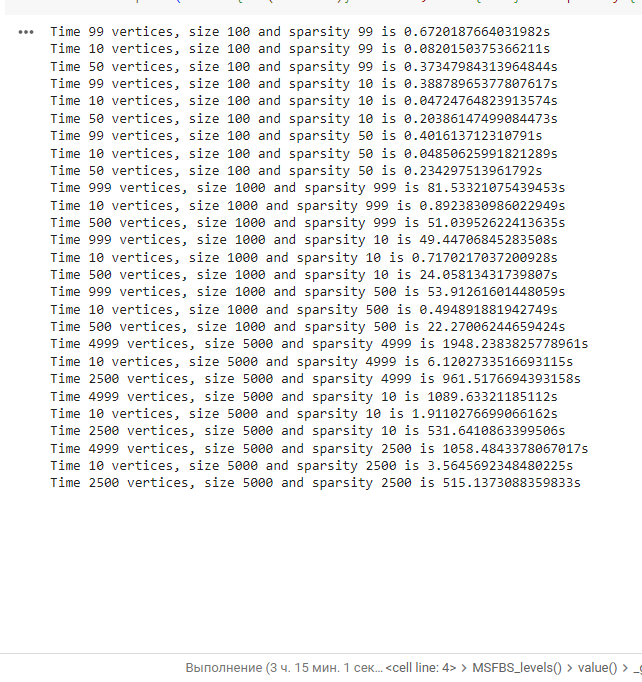

In [102]:
for size in sizes:
  sparsities = [size - 1, 10, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
    vertices_ = [list(range(size - 1)), list(range(10)), list(range(size // 2))]
    for vertices in vertices_:
        start = time.time()
        MSFBS_parents(generate_random_graph(size, sparsity), vertices)
        print(f"Time {len(vertices)} vertices, size {size} and sparsity {sparsity} is {time.time() - start}s")

Time 99 vertices, size 100 and sparsity 99 is 0.5515294075012207s
Time 10 vertices, size 100 and sparsity 99 is 0.058817386627197266s
Time 50 vertices, size 100 and sparsity 99 is 0.2427217960357666s
Time 99 vertices, size 100 and sparsity 10 is 0.3006429672241211s
Time 10 vertices, size 100 and sparsity 10 is 0.03180408477783203s
Time 50 vertices, size 100 and sparsity 10 is 0.16547250747680664s
Time 99 vertices, size 100 and sparsity 50 is 0.3736727237701416s
Time 10 vertices, size 100 and sparsity 50 is 0.040396690368652344s
Time 50 vertices, size 100 and sparsity 50 is 0.17775917053222656s
Time 999 vertices, size 1000 and sparsity 999 is 35.036843061447144s
Time 10 vertices, size 1000 and sparsity 999 is 0.49077272415161133s
Time 500 vertices, size 1000 and sparsity 999 is 17.14122986793518s
Time 999 vertices, size 1000 and sparsity 10 is 28.051719903945923s
Time 10 vertices, size 1000 and sparsity 10 is 0.25895023345947266s
Time 500 vertices, size 1000 and sparsity 10 is 14.411349

KeyboardInterrupt: 

In [103]:
for size in sizes:
  sparsities = [size - 1, 10, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
    vertices_ = [list(range(10)), list(range(20)), list(range(99))]
    for vertices in vertices_:
        start = time.time()
        MSFBS_parents(generate_random_graph(size, sparsity), vertices)
        print(f"Time {len(vertices)} vertices, size {size} and sparsity {sparsity} is {time.time() - start}s")

Time 10 vertices, size 100 and sparsity 99 is 0.2884695529937744s
Time 20 vertices, size 100 and sparsity 99 is 0.5711135864257812s
Time 99 vertices, size 100 and sparsity 99 is 1.1982550621032715s
Time 10 vertices, size 100 and sparsity 10 is 0.06617045402526855s
Time 20 vertices, size 100 and sparsity 10 is 0.18420720100402832s
Time 99 vertices, size 100 and sparsity 10 is 0.5206799507141113s
Time 10 vertices, size 100 and sparsity 50 is 0.03949403762817383s
Time 20 vertices, size 100 and sparsity 50 is 0.07585740089416504s
Time 99 vertices, size 100 and sparsity 50 is 0.3595092296600342s
Time 10 vertices, size 1000 and sparsity 999 is 0.459871768951416s
Time 20 vertices, size 1000 and sparsity 999 is 0.7822592258453369s
Time 99 vertices, size 1000 and sparsity 999 is 3.2820024490356445s
Time 10 vertices, size 1000 and sparsity 10 is 0.2593405246734619s
Time 20 vertices, size 1000 and sparsity 10 is 0.5401062965393066s
Time 99 vertices, size 1000 and sparsity 10 is 2.5175633430480957

KeyboardInterrupt: 

In [104]:
for size in sizes:
  sparsities = [size - 1, 10, size // 2] #неразреженная матрица, разреженная, и 50/50
  for sparsity in sparsities:
    vertices_ = [list(range(10)), list(range(20)), list(range(99))]
    for vertices in vertices_:
        start = time.time()
        MSFBS_levels(generate_random_graph(size, sparsity), vertices)
        print(f"Time {len(vertices)} vertices, size {size} and sparsity {sparsity} is {time.time() - start}s")

Time 10 vertices, size 100 and sparsity 99 is 0.0923166275024414s
Time 20 vertices, size 100 and sparsity 99 is 0.16899681091308594s
Time 99 vertices, size 100 and sparsity 99 is 0.7239267826080322s
Time 10 vertices, size 100 and sparsity 10 is 0.04020404815673828s
Time 20 vertices, size 100 and sparsity 10 is 0.07996225357055664s
Time 99 vertices, size 100 and sparsity 10 is 0.40021443367004395s
Time 10 vertices, size 100 and sparsity 50 is 0.061163902282714844s
Time 20 vertices, size 100 and sparsity 50 is 0.10423398017883301s
Time 99 vertices, size 100 and sparsity 50 is 0.3996157646179199s
Time 10 vertices, size 1000 and sparsity 999 is 0.9512171745300293s
Time 20 vertices, size 1000 and sparsity 999 is 1.6725420951843262s
Time 99 vertices, size 1000 and sparsity 999 is 8.399077892303467s
Time 10 vertices, size 1000 and sparsity 10 is 0.6664307117462158s
Time 20 vertices, size 1000 and sparsity 10 is 1.5034599304199219s
Time 99 vertices, size 1000 and sparsity 10 is 4.1866219043731

KeyboardInterrupt: 

тестируем время выполнения MSFBS_levels

При увеличении количества стартовых вершин – увеличивается время выполнения
При увеличении размера графа – увеличивается время выполнения
Чем разреженее граф, тем меньше время выполнение.


In [87]:
for m in M:
        start = time.time()
        MSFBS_levels(m, vertices)
        print(f"Time {m.nrows} vertices and nonzeros {m.nvals} is {time.time() - start}s")


Time 6927 vertices and nonzeros 16944 is 1.863823652267456s
Time 5488 vertices and nonzeros 14170 is 2.1962616443634033s
Time 5822 vertices and nonzeros 14750 is 1.6440470218658447s
Time 6100 vertices and nonzeros 15030 is 1.4226353168487549s
Time 2048 vertices and nonzeros 12254 is 0.5446221828460693s
Time 23133 vertices and nonzeros 186936 is 5.816061496734619s
Time 8192 vertices and nonzeros 49094 is 2.8471436500549316s
Time 16384 vertices and nonzeros 98244 is 5.150265216827393s
Time 4096 vertices and nonzeros 24528 is 1.2177503108978271s
Time 32768 vertices and nonzeros 196548 is 11.353052139282227s


тестируем время выполнения MSFBS_parents

При увеличении количества стартовых вершин – увеличивается время выполнения
При увеличении размера графа – увеличивается время выполнения
Чем разреженее граф, тем меньше время выполнение. У "среднего" по разреженности графа получились наилучшее время


In [88]:
import time

for m in M:
        start = time.time()
        MSFBS_parents(m, vertices)
        print(f"Time {m.nrows} rows, {m.ncols} cols and nonzeros {m.nvals} is {time.time() - start}s")


Time 6927 rows, 6927 cols and nonzeros 16944 is 1.222470998764038s
Time 5488 rows, 5488 cols and nonzeros 14170 is 0.5095062255859375s
Time 5822 rows, 5822 cols and nonzeros 14750 is 0.5562257766723633s
Time 6100 rows, 6100 cols and nonzeros 15030 is 0.6076211929321289s
Time 2048 rows, 2048 cols and nonzeros 12254 is 0.22636127471923828s
Time 23133 rows, 23133 cols and nonzeros 186936 is 2.236506223678589s
Time 8192 rows, 8192 cols and nonzeros 49094 is 0.8522815704345703s
Time 16384 rows, 16384 cols and nonzeros 98244 is 1.6312179565429688s
Time 4096 rows, 4096 cols and nonzeros 24528 is 0.4186058044433594s
Time 32768 rows, 32768 cols and nonzeros 196548 is 4.297213315963745s


самое долгое время выполнения у сильно разреженных графов с большим количество вершин, самое маленькое - с наименьшим количеством вершин

 * (+3 балла) Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

In [44]:
import graphblas as gb
from graphblas import Matrix, Vector, binary, semiring, dtypes

def MSFBS_parents_any_first(A, vertices):
    N = A.nrows
    index_ramp = Vector(dtypes.UINT64, N)
    index_ramp.build(range(N), range(N))
    output = []
    for vertex in vertices:
        parents = Vector(dtypes.INT64, N)
        parents[vertex] << -1
        wavefront = Vector(dtypes.INT64, N)
        wavefront[vertex] << 1
        while wavefront.nvals > 0:
            wavefront << index_ramp.ewise_mult(wavefront, binary.first)
            wavefront(~parents.S, replace=True) << wavefront.vxm(A, semiring.any_first)
            parents(binary.plus) << wavefront
        output.append((vertex, [parents.get(i, default=-2) for i in range(N)]))
    return output

MSFBS_parents_any_first(A, vertices)

[(1, [3, -1, 6, 6, 1, 4, 1]),
 (2, [-2, -2, -1, -2, -2, 2, -2]),
 (3, [3, 0, 3, -1, 1, 2, 1])]

In [53]:
import graphblas as gb

def MSFBS_levels_any_pair(A, vertices):
    n = A.nrows
    result = gb.Matrix(int, len(vertices), n)  # vector for result with levels

    #колво столбцов = колво верщин графа, колво строк = колво стартовых вершин
    f = gb.Matrix(int, len(vertices), n)  # frontier

    for i in range (len(vertices)):
        f[i, vertices[i]]<< True #создать пустую матрицу и проставить единички в цикле

    succ =Vector(bool,len(vertices))
    #matrix = gb.Matrix.from_vectors([f1, f2, f3])
    level = 0  # level in BFS traversal
    while True:
        # Assign the depth level to the frontier
        result(f.V) << level

        # Compute the next frontier, masking out anything already assigned
        f(~result.S, replace=True) << f.mxm(A, gb.semiring.any_pair)

        # If the next frontier is empty, we're done
        succ << f.reduce_rowwise(monoid.lor)
        level += 1

        if succ.nvals == 0:
          break


    output = []
    for i, vertex in enumerate(vertices):
        levels = []
        for j in range(n):
            levels.append(result[i, j].value if result[i, j].value is not None or j == vertex else -1)
        output.append((vertex, levels))

    return output
vertices=[0,2,3]
MSFBS_levels_any_pair(A, vertices)

[(0, [0, 1, 2, 1, 2, 3, 2]),
 (2, [-1, -1, 0, -1, -1, 1, -1]),
 (3, [1, 2, 1, 0, 3, 2, 3])]

Значения, полученные двумя способами, совпадают